# DeepWave Training

This notebook presents a simple training scheme of DeepWave PyTorch using the dataloaders from the original DeepWave implementation. 

For the sake of an illustration, we generate a very primitive training loop with 28 training data points. No hyper-parameter tuning was applied. Nevertheless, by using such a raw training loop, we can still clearly observe that the network does learn how to localize and represent sound intensity fields.

In [2]:
# Import libraries needed by DeepWave NumPy
import numpy as np
import deepwave.nn as nn
import deepwave.tools.math.func as func
import deepwave.tools.math.graph as graph
import deepwave.nn.crnn as deepwave_numpy # NumPy DeepWave model

In [7]:
# Import libraries needed by DeepWave PyTorch
import torch
import torch.optim as optim
from deepwavetorch.models.deepwave import DeepWave as deepwave_torch # PyTorch DeepWave model

In [13]:
D = nn.DataSet.from_file("/home/asroman/repos/DeepWave/datasets/FRIDA/dataset/D_1-5_freq0_cold.npz") # 0th frequency training data
Pf = np.load("/home/asroman/repos/DeepWave/datasets/FRIDA/dataset/D_freq0_train.npz") # trained model parameters
N_antenna = D.XYZ.shape[1] # number of microphones in the array data
N_px = D.R.shape[1] # number of pixels in the intensity map
K = int(Pf['K']) # Chev filter polynomial order
N_layer = Pf['N_layer']
print("Number of layers:", N_layer)
print("Num antenna:", N_antenna)
print("Num pixels:", N_px)
print("Filter Kth:", K)
parameter = deepwave_numpy.Parameter(N_antenna, N_px, K)
sampler = Df.sampler()

Number of layers: 5
Num antenna: 48
Num pixels: 2234
Filter Kth: 22


## Retrieve pre-trained parameters of the fully trained original DeepWave 

In [14]:
p_opt = Pf['p_opt'][np.argmin(Pf['v_loss'])]
p_mu, p_D, p_tau = parameter.decode(p_opt) # Load pre-trained parameters

## Define DeepWave model without pre-trained parameters

In [19]:
# DeepWave model initialization 
batch_sz = 1
pretr_params = None
deepwave_tr = deepwave_torch(R=D.R, kernel_size=K, Nch=N_antenna, Npx=N_px,
                 batch_size=batch_sz, depth=1, pretr_params=pretr_params)

# Training parameters
N_epoch = 10
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(deepwave_tr.parameters(), lr=1e-6)

In [20]:
# Load training and validation datasets
tv_ratio = 0.1 # train vs. validation ratio 
S, I, _ = sampler.decode(D[:])
sample_mask = ~np.isclose(I.sum(axis=1), 0)
# Random split
idx_valid = np.flatnonzero(sample_mask)
idx_sample = np.random.permutation(idx_valid)

N_sample = len(idx_valid)
idx_ts = idx_sample[int(N_sample * tv_ratio):]
idx_vs = idx_sample[:int(N_sample * tv_ratio)]


D_ts = nn.DataSet(D[idx_ts], D.XYZ, D.R, D.wl,
                  ground_truth=[D.ground_truth[idx] for idx in idx_ts],
                  lambda_=np.array([np.median(D.lambda_[idx_ts])] * len(idx_ts)),
                  gamma=D.gamma,
                  N_iter=D.N_iter[idx_ts],
                  tts=D.tts[idx_ts])
D_vs = nn.DataSet(D[idx_vs], D.XYZ, D.R, D.wl,
                  ground_truth=[D.ground_truth[idx] for idx in idx_vs],
                  lambda_=np.array([np.median(D.lambda_[idx_vs])] * len(idx_vs)),
                  gamma=D.gamma,
                  N_iter=D.N_iter[idx_vs],
                  tts=D.tts[idx_vs])

ts = D_ts # training set
vs = D_vs # validation set
print("Length of training set", len(ts))
print("Length of validation set", len(vs))

Length of training set 28
Length of validation set 3


## Training loop

In [21]:
N_sample = (len(ts) // batch_size) * batch_size
N_batch = N_sample // batch_size

for epoch_idx in range(N_epoch):
    sample_idx = (np.random.permutation(np.arange(N_sample)).reshape(N_batch, -1))

    for batch_idx in range(N_batch):
        x = ts[sample_idx[batch_idx]]
        S, I, _ = sampler.decode(x, keepdims=True) # inputs, labels
        S = torch.from_numpy(S)
        I = torch.from_numpy(I).double()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = deepwave_tr(S)
        loss = criterion(outputs, I)
        print("Loss:", loss)
        loss.backward()
        optimizer.step()
print('Finished Training')

Loss: tensor(1.1923e-09, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(1.2224e-09, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(1.9740e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(1.1571e-09, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(6.9323e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(1.3080e-09, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(1.8162e-09, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(1.3728e-09, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(4.9787e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(7.1304e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(3.0578e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(1.0253e-09, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(1.4712e-09, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(1.8523e-09, dtype=torch.f

Loss: tensor(8.6702e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(3.0886e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(6.5342e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(7.8944e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(1.0812e-09, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(8.6564e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(1.3646e-09, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(1.1107e-09, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(1.0648e-09, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(4.9835e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(8.7070e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(1.3861e-09, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(9.6177e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(5.4736e-10, dtype=torch.f

Loss: tensor(3.8661e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(4.7416e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(8.4869e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(6.8369e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(5.1479e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(4.1861e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(7.1810e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(1.2673e-09, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(9.2368e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(5.8083e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(9.9045e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(7.7850e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(8.9678e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Loss: tensor(1.1815e-09, dtype=torch.f

**Note**: in the above example we have only trained the DeepWave PyTorch model with a single track, using 28 datapoints. We should expect a clear difference when generating intensity fields with this trained model against the original DeepWave model which was trained with a full training set from the FRIDA dataset.

In [23]:
###### Plotting Utils #######
# Refer to: https://github.com/imagingofthings/DeepWave/blob/master/datasets/Pyramic/color_plot.py 
import matplotlib.pyplot as plt
import imot_tools.math.sphere.transform as transform
import astropy.coordinates as coord
import astropy.units as u
import collections.abc as abc

from matplotlib.colors import LinearSegmentedColormap

def wrapped_rad2deg(lat_r, lon_r):
    """
    Equatorial coordinate [rad] -> [deg] unit conversion.
    Output longitude guaranteed to lie in [-180, 180) [deg].
    """
    lat_d = coord.Angle(lat_r * u.rad).to_value(u.deg)
    lon_d = coord.Angle(lon_r * u.rad).wrap_at(180 * u.deg).to_value(u.deg)
    return lat_d, lon_d

def cmap_from_list(name, colors, N=256, gamma=1.0):
    """
    Parameters
    ----------
    name : str
    colors :
        * a list of (value, color) tuples; or
        * list of color strings
    N : int
        Number of RGB quantization levels.
    gamma : float
        Something?

    Returns
    -------
    cmap : :py:class:`matplotlib.colors.LinearSegmentedColormap`
    """
    from collections import Sized
    import matplotlib.colors

    colors_len = len(colors)
    colors = np.append(colors, np.zeros(colors_len*2))
    colors = colors.reshape((3, colors_len))
    colors = colors.T
    if not isinstance(colors, abc.Iterable):
        raise ValueError('colors must be iterable')

    if (isinstance(colors[0], Sized) and
        (len(colors[0]) == 2) and
        (not isinstance(colors[0], str))):  # List of value, color pairs
        vals, colors = zip(*colors)
    else:
        vals = np.linspace(0, 1, len(colors))

    cdict = dict(red=[], green=[], blue=[], alpha=[])
    for val, color in zip(vals, colors):
        r, g, b, a = matplotlib.colors.to_rgba(color)
        cdict['red'].append((val, r, r))
        cdict['green'].append((val, g, g))
        cdict['blue'].append((val, b, b))
        cdict['alpha'].append((val, a, a))

    return matplotlib.colors.LinearSegmentedColormap(name, cdict, N, gamma)

def draw_map(I, R, lon_ticks, catalog=None, show_labels=False, show_axis=False):
    import mpl_toolkits.basemap as basemap
    import matplotlib.tri as tri

    _, R_el, R_az = transform.cart2eq(*R)
    R_el, R_az = wrapped_rad2deg(R_el, R_az)
    R_el_min, R_el_max = np.around([np.min(R_el), np.max(R_el)])
    R_az_min, R_az_max = np.around([np.min(R_az), np.max(R_az)])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    bm = basemap.Basemap(projection='mill',
                         llcrnrlat=R_el_min, urcrnrlat=R_el_max,
                         llcrnrlon=R_az_min, urcrnrlon=R_az_max,
                         resolution='c',
                         ax=ax)

    if show_axis:
        bm_labels = [1, 0, 0, 1]
    else:
        bm_labels = [0, 0, 0, 0]
    bm.drawparallels(np.linspace(R_el_min, R_el_max, 5),
                    color='w', dashes=[1, 0], labels=bm_labels, labelstyle='+/-',
                    textcolor='#565656', zorder=0, linewidth=2)
    bm.drawmeridians(lon_ticks,
                    color='w', dashes=[1, 0], labels=bm_labels, labelstyle='+/-',
                    textcolor='#565656', zorder=0, linewidth=2)

    if show_labels:
        ax.set_xlabel('Azimuth (degrees)', labelpad=20)
        ax.set_ylabel('Elevation (degrees)', labelpad=40)

    R_x, R_y = bm(R_az, R_el)
    triangulation = tri.Triangulation(R_x, R_y)

    N_px = len(I)
    min_val, max_val = I.min(), I.max()
    colors = [(0, 0, 0), (1, 0, 0)] # first color is black, last is red
    mycmap = cmap_from_list('mycmap', I/I.max(), N=N_px)
    colors_cmap = np.arange(N_px)
    ax.tripcolor(triangulation, colors_cmap, cmap=mycmap,
                 shading='gouraud', alpha=0.9, edgecolors='w', linewidth=0.1)

    if catalog is not None:
        _, sky_el, sky_az = transform.cart2eq(*catalog.xyz)
        sky_el, sky_az = wrapped_rad2deg(sky_el, sky_az)
        sky_x, sky_y = bm(sky_az, sky_el)
        ax.scatter(sky_x, sky_y, c='w', s=5)

    return fig, ax

In [24]:
# Generated tesselation for Robinson projection 
arg_lonticks = np.linspace(-180, 180, 5)
R = D.R
# Filter field to lie in specified interval
_, R_lat, R_lon = transform.cart2eq(*R)
_, R_lon_d = wrapped_rad2deg(R_lat, R_lon)
min_lon, max_lon = arg_lonticks.min(), arg_lonticks.max()
mask_lon = (min_lon <= R_lon_d) & (R_lon_d <= max_lon)
R_field = transform.eq2cart(1, R_lat[mask_lon], R_lon[mask_lon])

## Load datapoint for validating intensity fields representation (from validation set)

In [25]:
S, I, I_prev = sampler.decode(D_vs[0])

### DeepWave PyTorch trained from scratch (w/ 28 samples): generated intensity field

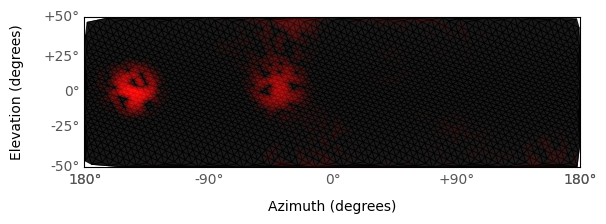

In [29]:
with torch.no_grad():
    I_deepwave_tr = deepwave_tr(torch.from_numpy(S).unsqueeze(0))
I_deepwave_tr = I_deepwave_tr.detach().numpy()[0,:]
fig, ax = draw_map(I_deepwave_tr, R_field,
                   lon_ticks=arg_lonticks,
                   catalog=None,
                   show_labels=True,
                   show_axis=True)

### Original DeepWave fully trained: generated intensity field

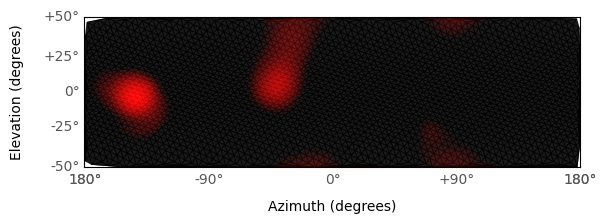

In [28]:
Ln, _ = graph.laplacian_exp(Df.R, normalized=True) 
afunc = lambda _: func.retanh(Pf['tanh_lin_limit'], _) 
deepwavenumpy = deepwave_numpy.Evaluator(N_layer, parameter, p_opt, Ln, afunc)

I_deepwave_orig = deepwavenumpy(S, I_prev) # generate intensity field with trained DeepWave original 
# DeepWave pre-trained intensity plot
fig, ax = draw_map(I_deepwave_orig, R_field,
                   lon_ticks=arg_lonticks,
                   catalog=None,
                   show_labels=True,
                   show_axis=True)

### DeepWave PyTorch w/ pre-trained weights of fully trained original DeepWave: generated intensity field

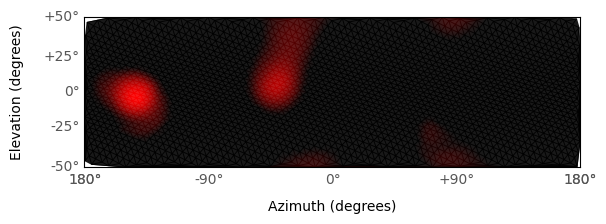

In [31]:
pretr_params = {"mu": torch.from_numpy(p_mu), 
                "tau": torch.from_numpy(p_tau),
                "D": torch.from_numpy(p_D)}

deepwave_pretr = deepwave_torch(R=D.R, kernel_size=K, Nch=N_antenna, Npx=N_px,
                 batch_size=1, depth=1, pretr_params=pretr_params)

with torch.no_grad():
    I_deepwave_pretr = deepwave_pretr(torch.from_numpy(S).unsqueeze(0))
I_deepwave_pretr = I_deepwave_pretr.detach().numpy()[0,:]
fig, ax = draw_map(I_deepwave_pretr, R_field,
                   lon_ticks=arg_lonticks,
                   catalog=None,
                   show_labels=True,
                   show_axis=True)

### Gound truth intensity field

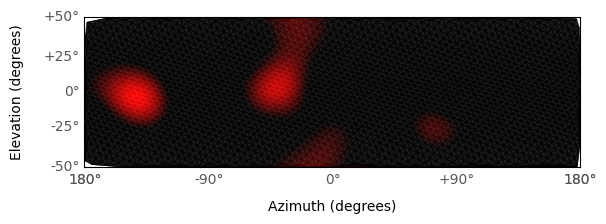

In [27]:
# Ground truth plot
I_ground_truth = I
fig, ax = draw_map(I_ground_truth, R_field,
                   lon_ticks=arg_lonticks,
                   catalog=None,
                   show_labels=True,
                   show_axis=True)